## Data Enhancement and Augmentation Techniques for Oculomotoric Biometric Identification using DeepEye

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)
import os
import socket

%load_ext autoreload
%autoreload 2
print(socket.gethostname())

2022-09-12 17:21:05.746175: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


DESKTOP-UK797EH


In [2]:
from Evaluation import evaluation
from tqdm import tqdm

## Download the data
* the data can be found here: 
    * Data/test_data.npz https://osf.io/g8rvb/download
    * Data/train_data.npz https://osf.io/s7vay/download
* the file structure should look like this:
    * Data/
    * ├── test_data.npz
    * └── train_data.npz

In [3]:
if not os.path.exists('Data/'):
    os.makedirs('Data/')
if not os.path.exists('Data/test_data.npz'):
    !wget -O Data/test_data.npz https://osf.io/g8rvb/download
if not os.path.exists('Data/train_data.npz'):
    !wget -O Data/train_data.npz https://osf.io/s7vay/download
        
if not os.path.exists('trained_models/'):
    os.makedirs('trained_models/')

## Set up the GPU you want to train on
* if you want to train on Google-Colab or the CPU you don't need to specify the GPU

In [4]:
flag_train_on_gpu = True
GPU = 0
if flag_train_on_gpu:
    import tensorflow as tf
    # select graphic card
    os.environ["CUDA_VISIBLE_DEVICES"] = str(GPU)
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    config = tf.compat.v1.ConfigProto(log_device_placement=True)
    config.gpu_options.per_process_gpu_memory_fraction = 0.5
    config.gpu_options.allow_growth = True
    tf_session = tf.compat.v1.Session(config=config)

2022-09-12 17:21:10.727949: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-12 17:21:10.729051: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-12 17:21:10.735473: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-09-12 17:21:10.977934: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2f:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-12 17:21:10.980093: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:2f:00.0 name: NVIDIA Ge

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:2f:00.0, compute capability: 7.5



2022-09-12 17:21:11.807704: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1261] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-09-12 17:21:11.807754: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1267]      0 
2022-09-12 17:21:11.807763: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1280] 0:   N 
2022-09-12 17:21:11.808200: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2f:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-12 17:21:11.808238: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1489] Could not identify NUMA node of platform GPU id 0, defaulting to 0.  Your kernel may not have been built with NUMA support.
2022-09-12 17:21:11.808313: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2f:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-0

## Load the data and the parameter for the model

In [5]:
Y_columns = {'subId': 0,
 'session': 1,
 'trialId': 2,
 'seqId': 3,
 'original_trial_length_before_padding': 4}

train_data = np.load('Data/train_data.npz')
test_data = np.load('Data/test_data.npz')
X_train = train_data['X_train']
Y_train = train_data['Y_train']
X_test = test_data['X_test']
Y_test = test_data['Y_test']

In [6]:
stds_per_row = np.std(X_train, axis=1)
stds_per_row_test = np.std(X_test, axis=1)

(array([4.0000e+00, 0.0000e+00, 2.0000e+00, 2.0000e+00, 2.4000e+01,
        1.8300e+02, 9.8700e+02, 2.6030e+03, 5.3930e+03, 8.4270e+03,
        1.1396e+04, 1.3072e+04, 1.3575e+04, 1.3122e+04, 1.2548e+04,
        1.1332e+04, 1.0020e+04, 8.3120e+03, 6.9760e+03, 5.4720e+03,
        4.5650e+03, 3.8090e+03, 3.1340e+03, 2.1480e+03, 1.6760e+03,
        1.3190e+03, 1.0660e+03, 8.5500e+02, 6.3000e+02, 4.4100e+02,
        2.9000e+02, 2.5800e+02, 1.6200e+02, 1.0900e+02, 4.8000e+01,
        3.1000e+01, 4.0000e+00, 3.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([0.        , 0.00276   , 0.00551999, 0.00827999, 0.01103999,
        0.01379998, 0.01655998, 0.01931998, 0.02207997, 0.02483997,
        0.02759996, 0.03035996, 0.03311996, 0.03587995, 0.03863995,
        0.04139995, 0.04415994, 0.04691994, 0.04967994, 0.05243993,
        0.05519993, 0.05795993, 0.06071992, 0.06347992, 0.06623992,
        0.06899991, 0.07175991, 0.07451991, 0.0772799 , 0.0800399 ,
        0.08279989, 0.08555989, 0.08831989, 0.

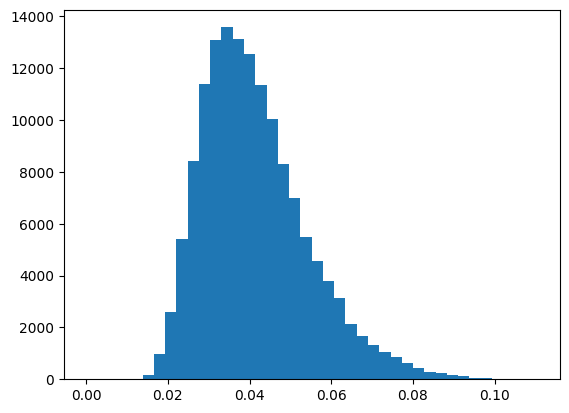

In [7]:
stds_per_row_all = np.mean(np.std(X_train, axis=1), axis=1)
plt.hist(stds_per_row_all, bins = 40)

In [8]:
# filter_mask = stds_per_row_all < 0.0625
filter_mask = stds_per_row_all > 0.025 
# stds_cut = stds_per_row_all[filter_mask]
# stds_cut = stds_
X_train_rand = X_train[filter_mask, :, :]
X_train_rand.shape
# plt.hist(stds_cut, bins = 40)

(134394, 1000, 4)

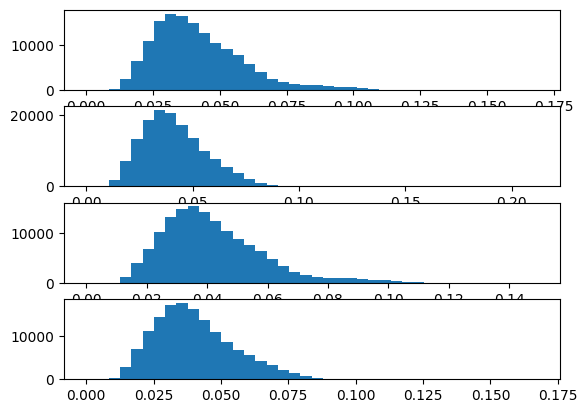

In [9]:
fig, axs = plt.subplots(4,1)
for x in range(4):
    axs[x].hist(stds_per_row[:, x], bins = 40)

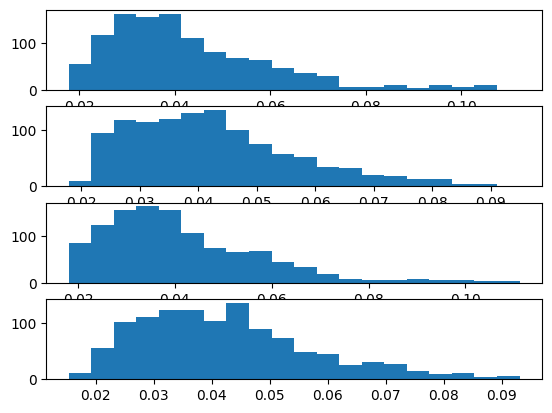

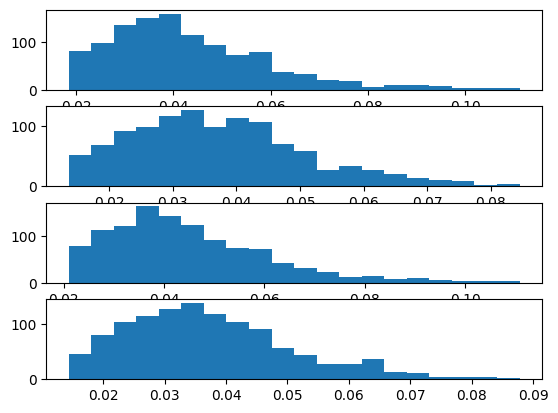

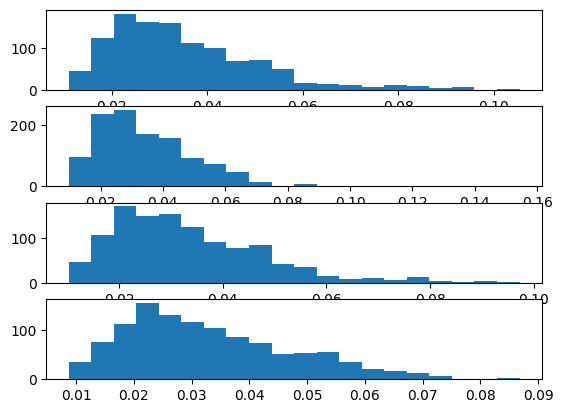

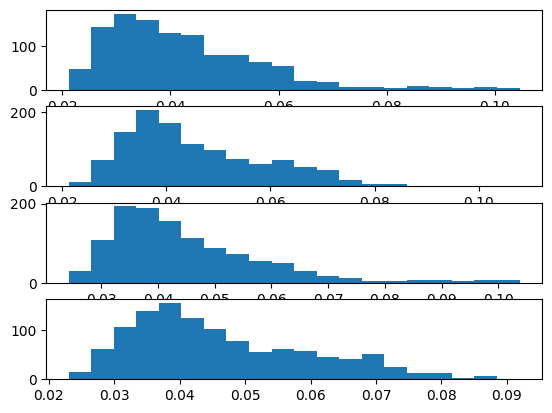

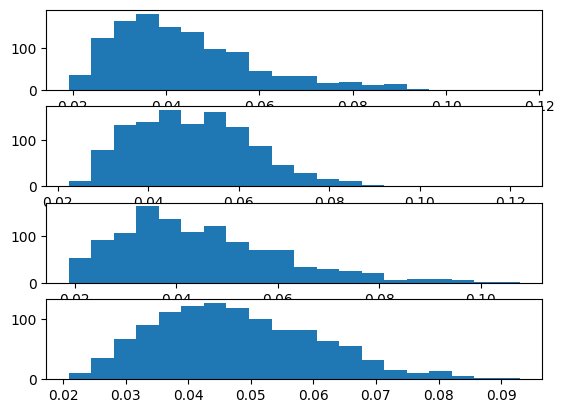

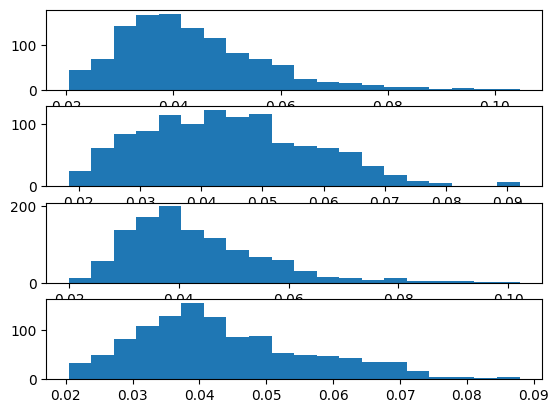

In [10]:
sub_id_std = {}
for idx, subId in enumerate(set(Y_test[:, 0])):
    mask = Y_test[:,0] == subId
    user_x = X_test[mask, :, :]
    stds_user = np.std(user_x, axis=1)

    fig, axs = plt.subplots(4,1)
    for x in range(4):
        axs[x].hist(stds_user[:, x], bins = 20)

    if idx == 5:
        break

In [11]:
# if you are running the notebook on Google-Colab or you don't have enough RAM 
# you can reduce the number of training/test samples by using only a subset
# of all sessions. In total there are 4 sessions (1,2,3,4). Uncomment the
# lines below to use only the first 2 sessions and the first 77 seqIDs

"""
sessions_use = [1.,2.]
seq_ids_use = np.arange(1,78,1)

train_ids = np.isin(Y_train[:,Y_columns['session']], sessions_use)
test_ids  = np.isin(Y_test[:,Y_columns['session']], sessions_use) 

X_train = X_train[train_ids]
Y_train = Y_train[train_ids]
X_test = X_test[test_ids]
Y_test = Y_test[test_ids]

train_ids = np.isin(Y_train[:,Y_columns['seqId']], seq_ids_use)
test_ids  = np.isin(Y_test[:,Y_columns['seqId']], seq_ids_use) 

X_train = X_train[train_ids]
Y_train = Y_train[train_ids]
X_test = X_test[test_ids]
Y_test = Y_test[test_ids]
"""

"\nsessions_use = [1.,2.]\nseq_ids_use = np.arange(1,78,1)\n\ntrain_ids = np.isin(Y_train[:,Y_columns['session']], sessions_use)\ntest_ids  = np.isin(Y_test[:,Y_columns['session']], sessions_use) \n\nX_train = X_train[train_ids]\nY_train = Y_train[train_ids]\nX_test = X_test[test_ids]\nY_test = Y_test[test_ids]\n\ntrain_ids = np.isin(Y_train[:,Y_columns['seqId']], seq_ids_use)\ntest_ids  = np.isin(Y_test[:,Y_columns['seqId']], seq_ids_use) \n\nX_train = X_train[train_ids]\nY_train = Y_train[train_ids]\nX_test = X_test[test_ids]\nY_test = Y_test[test_ids]\n"

### Show example instances of the data

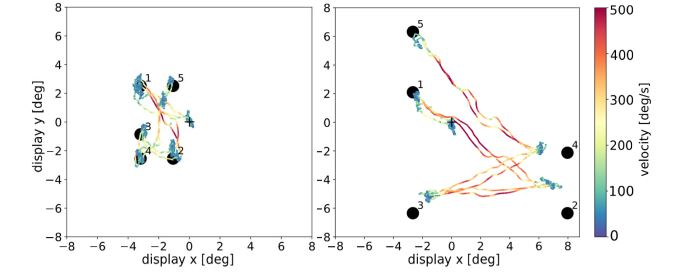

In [12]:
from IPython.display import Image
Image(filename='images/scanpaths.jpg')

## Apply the Data Augmentation/Enhancement
* Here you should implement your own data augmentation/enhancement
* implement the function 'transform(X_train,Y_train,Y_columns)' in 'DataAugmentation/data_augmentation.py'

In [13]:
def plot_train(sample_train):
    fig, ax = plt.subplots(1, 1, figsize=(4,4))
    x = [0]
    y = [0]
    for x_new, y_new in zip(sample_train[:, 0], sample_train[:, 1]):
        x.append(x[-1] + x_new)
        y.append(y[-1] + y_new)
    x = np.array(x) - np.mean(x)
    y = np.array(y) - np.mean(y)
    ax.plot(x, y, 'o', color='red')

    x = [0]
    y = [0]
    for x_new, y_new in zip(sample_train[:, 2], sample_train[:, 3]):
        x.append(x[-1] + x_new)
        y.append(y[-1] + y_new)
    x = np.array(x) - np.mean(x)
    y = np.array(y) - np.mean(y)
    ax.plot(x, y, 'o', color='blue')

    ax.set_xticks(np.arange(-4, 5, 1))
    ax.set_yticks(np.arange(-4, 5, 1))


def plot_multiple(sample_trains):
    for idx, sample_train in enumerate(sample_trains):
        plot_train(sample_train)


def plot_train_ax(sample_train, ax, one_eye=False):
    x = [0]
    y = [0]
    for x_new, y_new in zip(sample_train[:, 0], sample_train[:, 1]):
        x.append(x[-1] + x_new)
        y.append(y[-1] + y_new)
    x = np.array(x) - np.mean(x)
    y = np.array(y) - np.mean(y)
    ax.plot(x, y, '.', color='red')
    ax.set_xlabel("X Coordinates")
    ax.set_ylabel("Y Coordinates")

    if not one_eye:
        x = [0]
        y = [0]
        for x_new, y_new in zip(sample_train[:, 2], sample_train[:, 3]):
            x.append(x[-1] + x_new)
            y.append(y[-1] + y_new)
        x = np.array(x) - np.mean(x)
        y = np.array(y) - np.mean(y)
        ax.plot(x, y, 'o', color='blue')

    ax.set_xlabel("X Coordinates")
    ax.set_ylabel("Y Coordinates")
    ax.set_xticks(np.arange(-4, 5, 1))
    ax.set_yticks(np.arange(-4, 5, 1))

In [14]:
sample_train = X_train[0,:,:]
def jitter(sample, std):
    to_jitter = np.random.normal(0, std, (1000,4))
    return sample + to_jitter

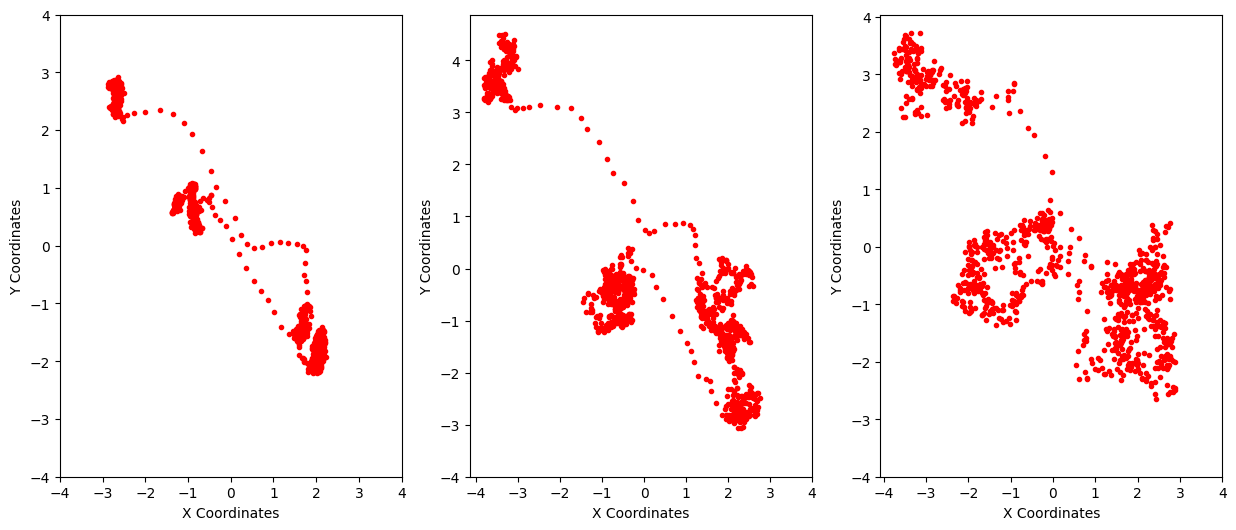

In [15]:
hyper_params = [0, 0.05, 0.1]
fig, ax = plt.subplots(1, len(hyper_params), figsize=(15,6))
for idx, alpha in enumerate(hyper_params):
    res = jitter(sample_train, alpha)
    plot_train_ax(res, ax[idx], True)
fig.savefig("./jitter.jpg")

In [16]:
from scipy.interpolate import CubicSpline
def mag_warp(x, sigma=0.2, knot=4):
    orig_steps = np.arange(x.shape[0])
    
    random_warps = np.random.normal(loc=1.0, scale=sigma, size=(x.shape[1], knot+2))
    warp_steps = (np.ones((x.shape[1], 1)) * (np.linspace(0, x.shape[0]-1., num=knot+2))).T
    warper = np.array([CubicSpline(warp_steps[:,dim], random_warps[dim,:])(orig_steps) for dim in range(x.shape[1])]).T
    return x * warper

def generate_warper(x, sigma, knot):
    orig_steps = np.arange(x.shape[0])
    random_warps = np.random.normal(loc=1.0, scale=sigma, size=(x.shape[1], knot+2))
    warp_steps = (np.ones((x.shape[1], 1)) * (np.linspace(0, x.shape[0]-1., num=knot+2))).T
    warper = np.array([CubicSpline(warp_steps[:,dim], random_warps[dim,:])(orig_steps) for dim in range(x.shape[1])]).T
    return warper

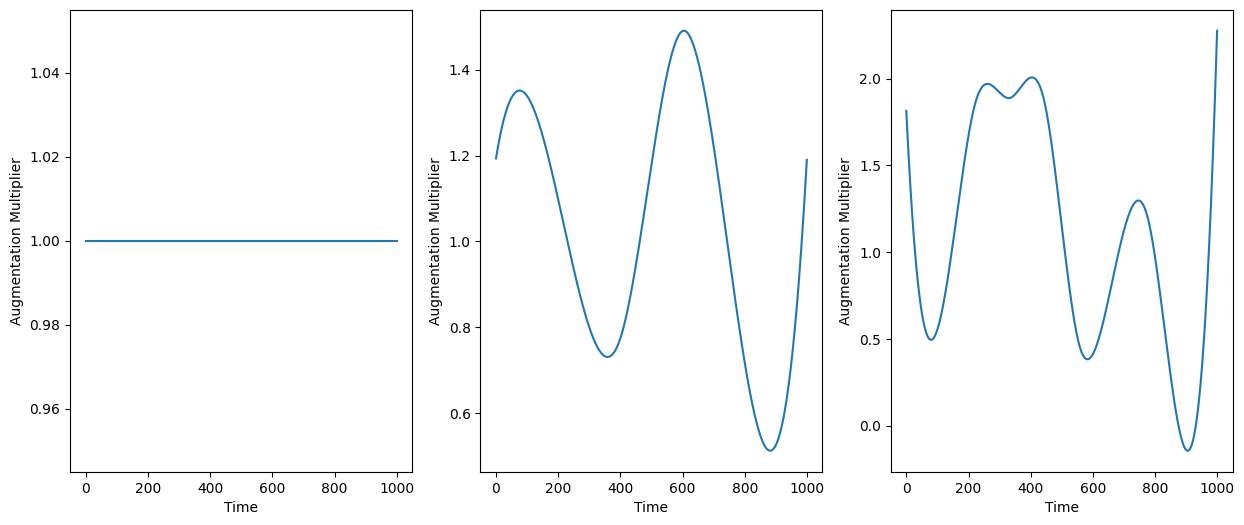

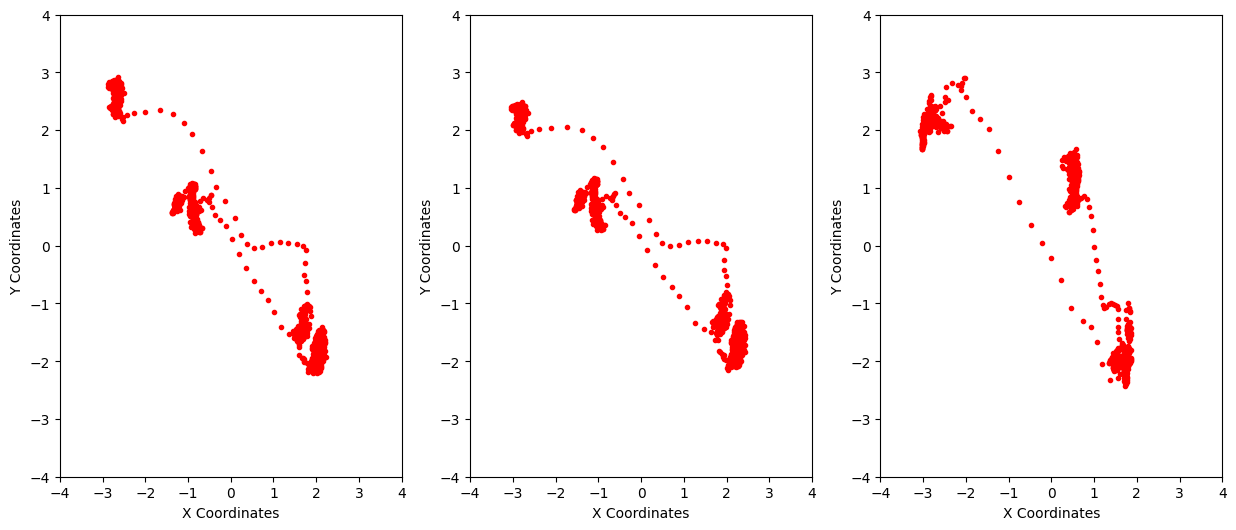

In [17]:
hyper_params = [(0, 4), (0.2, 4), (0.8, 8)]
fig, ax = plt.subplots(1, 3, figsize=(15,6))
for idx, param in enumerate(hyper_params):
    warper = generate_warper(sample_train, param[0], param[1])
    ax[idx].plot(range(0, 1000), warper[:,0])
    ax[idx].set_xlabel("Time")
    ax[idx].set_ylabel("Augmentation Multiplier")
fig.savefig("./magwarpline.jpg")

fig, ax = plt.subplots(1, len(hyper_params), figsize=(15,6))
for idx, param in enumerate(hyper_params):
    res = mag_warp(sample_train, param[0], param[1])
    plot_train_ax(res, ax[idx], True)
fig.savefig("./magwarp.jpg")

In [18]:
def convert_to_xy(sample_train):
    x = [0]
    y = [0]
    for x_new, y_new in zip(sample_train[:, 0], sample_train[:, 1]):
        x.append(x[-1] + x_new)
        y.append(y[-1] + y_new)
    return np.vstack([np.array(x), np.array(y)])


def center(x):
    return np.vstack([x[0,:] - np.mean(x[0,:]), x[1,:] - np.mean(x[1,:])])

def convert_to_angles(sample_train):
    x = []
    y = []
    for idx, (x_new, y_new) in enumerate(zip(sample_train[0, 1:], sample_train[1, 1:])):
        x.append(x_new - sample_train[0, idx])
        y.append(y_new - sample_train[1, idx])
    return np.vstack([x, y])

def rotate(sample_train, rotation_angle):
    rotation_mat = np.array([[np.cos(rotation_angle), - np.sin(rotation_angle)],
                             [np.sin(rotation_angle), np.cos(rotation_angle)]])
    return rotation_mat @ sample_train


def rotate_2d(x, max_rotation):
    left_eye = x[:, 0:2]
    right_eye = x[:, 2:4]
    
    left_eye = convert_to_xy(left_eye)
    right_eye = convert_to_xy(right_eye)

    left_eye = center(left_eye) 
    right_eye = center(right_eye) 

    rotation_angle = np.random.uniform(-max_rotation, max_rotation)
    left_eye = rotate(left_eye, rotation_angle)
    right_eye = rotate(right_eye, rotation_angle)

    left_eye = convert_to_angles(left_eye)
    right_eye = convert_to_angles(right_eye)

    return np.hstack([left_eye.T, right_eye.T])

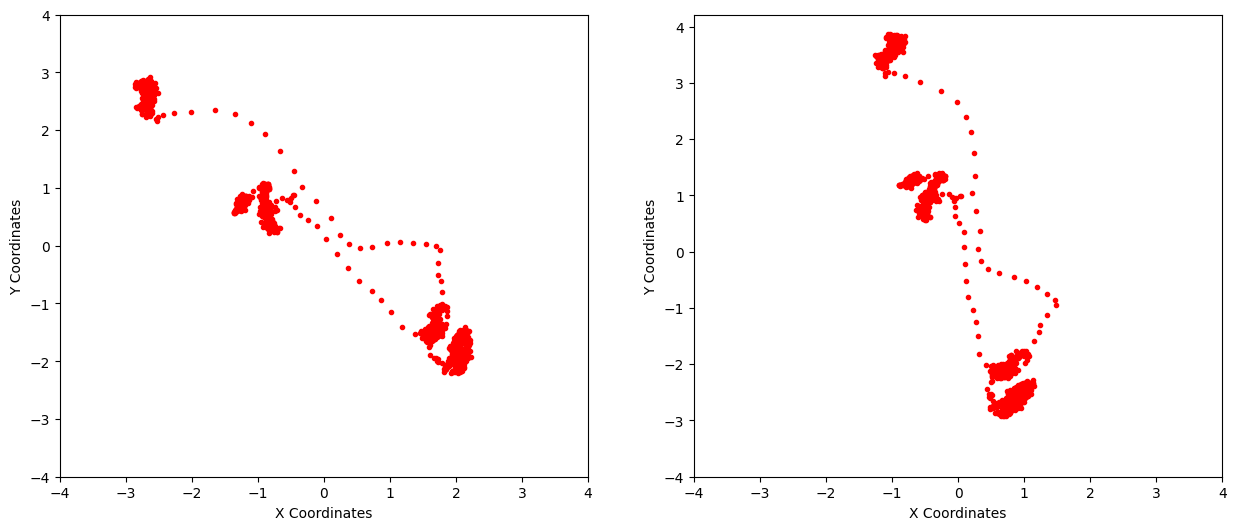

In [19]:
sample_train = X_train[0,:,:]
hyper_params = [0, 180]
fig, ax = plt.subplots(1, len(hyper_params), figsize=(15,6))
for idx, alpha in enumerate(hyper_params):
    res = rotate_2d(sample_train, alpha)
    plot_train_ax(res, ax[idx], True)
fig.savefig("./rotate.jpg")

In [20]:
def filter_high_std(X_train, Y_train, cutoff=0.065):
    stds_per_row_all = np.mean(np.std(X_train, axis=1), axis=1)
    filter_mask = stds_per_row_all < cutoff
    return X_train[filter_mask,:,:], Y_train[filter_mask, :]

def filter_low_std(X_train, Y_train, cutoff=0.025):
    stds_per_row_all = np.mean(np.std(X_train, axis=1), axis=1)
    filter_mask = stds_per_row_all > cutoff
    return X_train[filter_mask,:,:], Y_train[filter_mask, :]

In [21]:
### Generate solo transformations
# solo_configurations = [{}]
solo_configurations = []
for i in np.arange(0.0001, 0.03, 0.005):
    config = { 'jitter': np.around(i,4)}
    solo_configurations.append(config)

for i in np.arange(0.001, 0.3, 0.05):
    config = {'mag_warp': np.around(i, 4)}
    solo_configurations.append(config)

solo_configurations.append({"rotate": 0.1, "mag_warp": 0.001})

for i in np.arange(0.001, 0.008, 0.002):
    config = {'mag_warp': np.around(i, 4)}
    solo_configurations.append(config)

for i in range(5):
    config = { 'mag_warp': 0.001, 'run': i }
    solo_configurations.append(config)

for i in range(5):
    config = { 'cutoff_high': 0.065, 'mag_warp': 0.001, 'run': i }
    solo_configurations.append(config)

for i in range(5):
    config = { 'cutoff_low': 0.025, 'mag_warp': 0.001, 'run': i }
    solo_configurations.append(config)

for i in range(8):
    config = { 'mag_warp': 0.051, 'run': i }
    solo_configurations.append(config)
solo_configurations.append({ 'mag_warp': 0.0001 })

## Add all rotate configurations
solo_configurations.append({"rotate": 180})
solo_configurations.append({"rotate": 0.1})
solo_configurations.append({"rotate": 1.0})
solo_configurations.append({"rotate": 5.0})
for i in range(8):
    config = { 'rotate': 0.5, 'run': i }
    solo_configurations.append(config)

for i in range(4):
    solo_configurations.append({"run": i})

for i in range(8):
    solo_configurations.append({"run": i, "batch_size": 32})

for i in range(8):
    solo_configurations.append({'mag_warp': 0.15, "run": i, "batch_size": 32})

for knot in [2, 8]:
    for i in range(8):
        solo_configurations.append({'mag_warp': (0.15, knot), "run": i, "batch_size": 32})

solo_configurations

[{'jitter': 0.0001},
 {'jitter': 0.0051},
 {'jitter': 0.0101},
 {'jitter': 0.0151},
 {'jitter': 0.0201},
 {'jitter': 0.0251},
 {'mag_warp': 0.001},
 {'mag_warp': 0.051},
 {'mag_warp': 0.101},
 {'mag_warp': 0.151},
 {'mag_warp': 0.201},
 {'mag_warp': 0.251},
 {'rotate': 0.1, 'mag_warp': 0.001},
 {'mag_warp': 0.001},
 {'mag_warp': 0.003},
 {'mag_warp': 0.005},
 {'mag_warp': 0.007},
 {'mag_warp': 0.001, 'run': 0},
 {'mag_warp': 0.001, 'run': 1},
 {'mag_warp': 0.001, 'run': 2},
 {'mag_warp': 0.001, 'run': 3},
 {'mag_warp': 0.001, 'run': 4},
 {'cutoff_high': 0.065, 'mag_warp': 0.001, 'run': 0},
 {'cutoff_high': 0.065, 'mag_warp': 0.001, 'run': 1},
 {'cutoff_high': 0.065, 'mag_warp': 0.001, 'run': 2},
 {'cutoff_high': 0.065, 'mag_warp': 0.001, 'run': 3},
 {'cutoff_high': 0.065, 'mag_warp': 0.001, 'run': 4},
 {'cutoff_low': 0.025, 'mag_warp': 0.001, 'run': 0},
 {'cutoff_low': 0.025, 'mag_warp': 0.001, 'run': 1},
 {'cutoff_low': 0.025, 'mag_warp': 0.001, 'run': 2},
 {'cutoff_low': 0.025, 'mag_

In [22]:
def augment(X_train, Y_train, Y_columns, aug_config):
    X_cutoff, Y_cutoff = X_train.copy(), Y_train.copy()
    if 'cutoff_high' in aug_config:
        X_cutoff, Y_cutoff = filter_high_std(X_cutoff, Y_cutoff, aug_config['cutoff_high'])
    if 'cutoff_low' in aug_config:
        X_cutoff, Y_cutoff = filter_low_std(X_cutoff, Y_cutoff, aug_config['cutoff_low'])

    X_aug = np.zeros(X_cutoff.shape)
    for x in tqdm(range(X_cutoff.shape[0])):
    # for x in range(2):
        X_aug[x] = X_cutoff[x]
        for aug_type, hyper_params in aug_config.items():
            if aug_type == 'jitter':
                X_aug[x] = jitter(X_aug[x], hyper_params)
            if aug_type == 'mag_warp':
                if type(hyper_params) == tuple:
                    X_aug[x] = mag_warp(X_aug[x], hyper_params[0], hyper_params[1])
                else:
                    X_aug[x] = mag_warp(X_aug[x], hyper_params)
            if aug_type == 'rotate':
                X_aug[x] = rotate_2d(X_aug[x], hyper_params)
    return X_aug, Y_cutoff

## Train model and get embeddings

In [23]:
from DataAugmentation import data_augmentation
result_path = "experiment_results.pkl"
if os.path.exists(result_path):
    with open(result_path, "rb") as f:
        import pickle
        output_data = pickle.load(f)
else:
    output_data = {}

print(f"current data: {output_data.keys()}")

current data: dict_keys([(('jitter', 0.0001),), (('jitter', 0.0051),), (('jitter', 0.0101),), (('jitter', 0.0151),), (('jitter', 0.0201),), (('jitter', 0.0251),), (('rotate', 180),), (('rotate', 0.1),), (('rotate', 1.0),), (('rotate', 5.0),), (('rotate', 0.1), ('warp', 0.001)), (('rotate', 0.01),), (('rotate', 0.06),), (('rotate', 0.11),), (('rotate', 0.16),), (('run', 0),), (('run', 1),), (('run', 2),), (('run', 3),), (('run', 0), ('batch_size', 32)), (('run', 1), ('batch_size', 32)), (('run', 2), ('batch_size', 32)), (('run', 3), ('batch_size', 32)), (), (('mag_warp', 0.001),), (('mag_warp', 0.051),), (('mag_warp', 0.101),), (('mag_warp', 0.151),), (('mag_warp', 0.201),), (('mag_warp', 0.251),), (('rotate', 0.1), ('mag_warp', 0.001)), (('mag_warp', 0.003),), (('mag_warp', 0.005),), (('mag_warp', 0.007),), (('mag_warp', 0.001), ('run', 0)), (('mag_warp', 0.001), ('run', 1)), (('mag_warp', 0.001), ('run', 2)), (('mag_warp', 0.001), ('run', 3)), (('mag_warp', 0.001), ('run', 4)), (('cut

In [ ]:
## Code to remove data from the output_data so that they force re-run
# to_remove = [ x for x in output_data.keys() if x == () or  (len(x) == 3 and 'warp' == x[1][0])]
# print(to_remove)
# for x in to_remove:
#     output_data.pop(x)
# output_data.keys()

In [24]:
# if the batch_size is too high for your GPU/CPU uncomment the following line
#batch_size = 32

for aug_param in solo_configurations:
    key = tuple(aug_param.items())
    print(f"Running config: {key}")
    if key in output_data:
        print(f"skipping {aug_param}... already computed")
        continue
    batch_size = aug_param.get('batch_size', 32)
    tf.random.set_seed(42)
    X_train_augmented,Y_train_augmented = augment(X_train, Y_train, Y_columns, aug_param)
    embeddings_concatenated_augmented = evaluation.evaluate_create_test_embeddings(X_train_augmented,
                                                                               Y_train_augmented,
                                                                               X_test,Y_test,
                                                                               Y_columns,
                                                                               batch_size = batch_size)
    output_data[key] = embeddings_concatenated_augmented

    with open("experiment_results.pkl", "wb") as f:
        import pickle
        pickle.dump(output_data, f)

Running config: (('jitter', 0.0001),)
skipping {'jitter': 0.0001}... already computed
Running config: (('jitter', 0.0051),)
skipping {'jitter': 0.0051}... already computed
Running config: (('jitter', 0.0101),)
skipping {'jitter': 0.0101}... already computed
Running config: (('jitter', 0.0151),)
skipping {'jitter': 0.0151}... already computed
Running config: (('jitter', 0.0201),)
skipping {'jitter': 0.0201}... already computed
Running config: (('jitter', 0.0251),)
skipping {'jitter': 0.0251}... already computed
Running config: (('mag_warp', 0.001),)
skipping {'mag_warp': 0.001}... already computed
Running config: (('mag_warp', 0.051),)
skipping {'mag_warp': 0.051}... already computed
Running config: (('mag_warp', 0.101),)
skipping {'mag_warp': 0.101}... already computed
Running config: (('mag_warp', 0.151),)
skipping {'mag_warp': 0.151}... already computed
Running config: (('mag_warp', 0.201),)
skipping {'mag_warp': 0.201}... already computed
Running config: (('mag_warp', 0.251),)
skipp

In [25]:
with open("./metrics_dict.pkl", "rb") as f:
    import pickle
    metric_dicts = pickle.load(f)

metric_dicts.keys()

dict_keys([(('jitter', 0.0001),), (('jitter', 0.0051),), (('jitter', 0.0101),), (('jitter', 0.0151),), (('jitter', 0.0201),), (('jitter', 0.0251),), (('warp', 0.001),), (('warp', 0.051),), (('warp', 0.101),), (('warp', 0.151),), (('warp', 0.201),), (('warp', 0.251),), (('rotate', 180),), (('rotate', 0.1),), (('rotate', 1.0),), (('rotate', 5.0),), (('rotate', 0.1), ('warp', 0.001)), (('warp', 0.003),), (('warp', 0.005),), (('warp', 0.007),), (('rotate', 0.01),), (('rotate', 0.06),), (('rotate', 0.11),), (('rotate', 0.16),), (('warp', 0.001), ('run', 0)), (('warp', 0.001), ('run', 1)), (('warp', 0.001), ('run', 2)), (('warp', 0.001), ('run', 3)), (('warp', 0.001), ('run', 4)), (('warp', 0.0001),), (('warp', 0.051), ('run', 0)), (('warp', 0.051), ('run', 1)), (('warp', 0.051), ('run', 2)), (('warp', 0.051), ('run', 3)), (('warp', 0.051), ('run', 4)), (('cutoff_low', 0.025), ('warp', 0.001), ('run', 0)), (('cutoff_low', 0.025), ('warp', 0.001), ('run', 1)), (('cutoff_low', 0.025), ('warp',

In [ ]:
# to_remove = [ x for x in metric_dicts.keys() if x == () or  (len(x) == 1 and 'run' == x[0][0])]
# to_remove
# for x in to_remove:
#     metric_dicts.pop(x)
# metric_dicts.keys()

In [26]:
num_sessions = len(np.unique(Y_test[:,Y_columns['session']]))
print('number of sessions: ' + str(num_sessions))

window_sizes = [1,5,10]
n_train_users = 0
n_enrolled_users = 20
n_impostors = 5
n_enrollment_sessions = num_sessions -1
n_test_sessions = 1
test_user = None
test_sessions = None
user_test_sessions = None 
enrollment_sessions = None
verbose = 0
random_state = 42,
seconds_per_session = None

metric_lists = []
for k, v in output_data.items():
    if k in metric_dicts:
        continue
    print(f"processing {k}")
    metric_dict = dict()
    for random_state in tqdm(np.arange(10)):
        from sklearn import metrics
        (score_dicts, label_dicts) = evaluation.get_scores_and_labels_from_raw(
                                    test_embeddings=v,
                                    Y_test=Y_test,
                                    Y_columns=Y_columns,
                                    window_sizes=window_sizes,
                                    n_train_users = n_train_users,
                                    n_enrolled_users = n_enrolled_users,
                                    n_impostors = n_impostors,
                                    n_enrollment_sessions = n_enrollment_sessions,
                                    n_test_sessions = n_test_sessions,
                                    test_user = test_user,
                                    test_sessions = test_sessions,
                                    user_test_sessions = user_test_sessions,
                                    enrollment_sessions = enrollment_sessions,
                                    verbose = verbose,
                                    random_state = random_state,
                                    seconds_per_session = seconds_per_session)

        for window_size in window_sizes:
            window_size = str(window_size)
            cur_scores = score_dicts[window_size]
            cur_label  = label_dicts[window_size]
            fpr, tpr, thresholds = metrics.roc_curve(cur_label, cur_scores, pos_label=1)
            if window_size not in metric_dict:
                metric_dict[window_size] = dict()
            if 'fpr' not in  metric_dict[window_size]:
                metric_dict[window_size]['fpr'] = []
                metric_dict[window_size]['tpr'] = []
            metric_dict[window_size]['fpr'].append(fpr)
            metric_dict[window_size]['tpr'].append(tpr)
    metric_dicts[k] = metric_dict

with open("metrics_dict.pkl", "wb") as f:
    pickle.dump(metric_dicts, f)

number of sessions: 4


In [27]:
metric_dicts.keys()

dict_keys([(('jitter', 0.0001),), (('jitter', 0.0051),), (('jitter', 0.0101),), (('jitter', 0.0151),), (('jitter', 0.0201),), (('jitter', 0.0251),), (('warp', 0.001),), (('warp', 0.051),), (('warp', 0.101),), (('warp', 0.151),), (('warp', 0.201),), (('warp', 0.251),), (('rotate', 180),), (('rotate', 0.1),), (('rotate', 1.0),), (('rotate', 5.0),), (('rotate', 0.1), ('warp', 0.001)), (('warp', 0.003),), (('warp', 0.005),), (('warp', 0.007),), (('rotate', 0.01),), (('rotate', 0.06),), (('rotate', 0.11),), (('rotate', 0.16),), (('warp', 0.001), ('run', 0)), (('warp', 0.001), ('run', 1)), (('warp', 0.001), ('run', 2)), (('warp', 0.001), ('run', 3)), (('warp', 0.001), ('run', 4)), (('warp', 0.0001),), (('warp', 0.051), ('run', 0)), (('warp', 0.051), ('run', 1)), (('warp', 0.051), ('run', 2)), (('warp', 0.051), ('run', 3)), (('warp', 0.051), ('run', 4)), (('cutoff_low', 0.025), ('warp', 0.001), ('run', 0)), (('cutoff_low', 0.025), ('warp', 0.001), ('run', 1)), (('cutoff_low', 0.025), ('warp',

## Test Visualizations

In [ ]:
# to_evaluate = [(), (('warp', 0.001),), (('jitter', 0.0001),), (('warp', 0.051),),]
# to_evaluate = [(), (('warp', 0.001),),  (('warp', 0.0001),), (('warp', 0.001), ('run', 0),), (('warp', 0.001), ('run', 1),), (('warp', 0.001), ('run', 2),), (('warp', 0.001), ('run', 3),), (('warp', 0.001), ('run', 4),)]
# to_evaluate = [(), (('warp', 0.051),),  (('warp', 0.051), ('run', 0),), (('warp', 0.051), ('run', 1),), (('warp', 0.051), ('run', 2),), (('warp', 0.051), ('run', 3),), (('warp', 0.051), ('run', 4),)]
to_evaluate = [ x for x in metric_dicts.keys() if x == () or  x[0][0] == 'cutoff_high' ]

for window_size in window_sizes:
    # for i, k in enumerate(metric_dicts.keys()):
    for i, (k, v) in enumerate(metric_dicts.items()):
        if k not in to_evaluate:
            continue
        metric_dict = v
        model_name = k
        if i == 0:
            plot_random = True
        else:
            plot_random = False
        window_size = str(window_size)
        evaluation.avg_fnr_fpr_curve(metric_dict[window_size]['fpr'], metric_dict[window_size]['tpr'], 
                label = model_name, plot_random=plot_random,
                title = 'Window_size: ' + window_size, plot_statistics = False,
                loc = 'upper right', plot_legend = True,
                plot_points = 1000, ncol=1,
                bbox_to_anchor=None,
                starting_point = None,
                fontsize = 14, xscale = 'log',
                setting = 'identification')
    plt.show()